in this tutorial, we will focus on the pro-con and the narrative generation services. We will run it on a set of arguments collected from the crowd for the "That's debatable" show. The crowd was asked to contribute arguments for or against the topic "It is time to redistribute the wealth". In this tutorial, we will start to run the pro-con service, in order to predict whether an argument is for or against the topic, we will see how we can improve the classification results, and finally, we will use these predictions in order to generate a narrative for the topic. 

# 1. Run pro con service on arguments collected from the crowd 

We will start with reading the arguments from a csv file, define the topic, and create a debater_api object

In [1]:
import os
from debater_python_api.api.debater_api import DebaterApi
from debater_python_api.api.clients.narrative_generation_client import Polarity
import csv


api_key = os.environ['API_KEY']
debater_api = DebaterApi(api_key)
arguments_file = 'wealth_test_set.csv'
topic = 'It is time to redistribute the wealth'

with open(arguments_file, encoding='utf8') as csv_file:
    reader = csv.DictReader(csv_file)
    examples = list(reader)
    arguments = [example['sentence'] for example in examples]
    labels = [example['label'] for example in examples]

Now we are ready to run the pro con service. The pro con service gets a list of dictionaries where each dictionary contains two keys: an argument and a topic. (e.g. arg_topic_dicts = [{'sentence': 'first sentence', 'topic': 'first topic'}, {'sentence': 'second sentence', 'topic': 'second topic'}] 

The service returns a list of floats in the range [-1, 1], where each float is the prediction (score) for the corresponding sentence and topic. The sign of the score indicated if the service predicts that the argument supports the motion (positive score), or contests the topic (negative score). The absolute value of the score indicated the confidence of the service. A low value indicates low confidence, while a high value indicates strong confidenec.

Decumantation for the pro-con service: https://early-access-program.debater.res.ibm.com/#pro_con


Next, you will write a code that run the pro-con service on the arguments list.

Please write a code that create a pro_con_client by calling the method get_pro_con_client() of the debater_api object.
Create a list with the arguments we got from the crowd while using the topic we defined, and run the pro con client on the list, while storing the results at a list with the name pro_con_scores.

In [9]:
pro_con_client = debater_api.get_pro_con_client()
sentence_topic_dicts = [{'sentence': argument, 'topic': topic} for argument in arguments]
pro_con_scores = pro_con_client.run(sentence_topic_dicts)

ProConClient: 100%|██████████| 507/507 [00:14<00:00, 449.75it/s]

# 2. Use pro con results
Now, we can use the service results and measure it accuracy. We will compare the service prediction to the labels created by human annotators. The label field contains three possible values: '1' for supporting arguments, '-1' for contesting arguments, and '0' for neutral or mixed arguments.

We will measure how many arguments were classified as supporting arguments, and what is the amount of arguments that were labeled as supporting arguments from this set, and print the accuracy of the prediction. 

We will repeat these steps for the contesting arguments as well. 

In [3]:
argument_score_label_list = list(zip(arguments, pro_con_scores, labels))

predicted_pro = [triple for triple in argument_score_label_list if triple[1] > 0]
predicted_pro_labeled_pro = [triple for triple in predicted_pro if triple[2] == '1']
print('predicted pro accuracy {}'.format(len(predicted_pro_labeled_pro) / len(predicted_pro)))

predicted_con = [triple for triple in argument_score_label_list if triple[1] < 0]
predicted_con_labeled_con = [triple for triple in predicted_con if triple[2] == '-1']
print('predicted con accuracy {}'.format(len(predicted_con_labeled_con) / len(predicted_con)))


predicted pro accuracy 0.6908517350157729
predicted con accuracy 0.7263157894736842


# 3. Exploring the polarity errors:
We saw that the accuracy of our classifier is about 70%. This is very nice result, but let's look at the arguments that we missed and try to understand if we can improve.

In [4]:
def sign(x):
    if x > 0:
        return '1'
    return '-1'


arguments_with_wrong_polarity = [triple for triple in argument_score_label_list if sign(triple[1]) != triple[2]]
print('Arguments with wrong polarity:')
for triple in arguments_with_wrong_polarity[:10]:
    print('score: {}, label: {}, argument: {}'.format(triple[1], triple[2], triple[0]))

Arguments with wrong polarity:
score: 0.33737299777567387, label: 0, argument: The redistribution of income and the redistribution of wealth are, respectively, the transfer of income and wealth
score: -0.033621422946453094, label: 0, argument: access to economic-occupational opportunity structures would not be given by
factors particular to the youth group, but would be linked to factors affecting
the whole society regardless of the generational
score: -0.5180366635322571, label: 0, argument: It would not be so much like distributing wealth, it would be more at the same time changing and reconverting the tax system
score: 0.9841152523877099, label: -1, argument: Meritocracy is the only way to personal and business success, persevering thinking along with sacrificial actions should be rewarded.
score: 0.8739315569400787, label: -1, argument: If you work hard and succeed it is only right that you are able to keep your hard earned benefits
score: 0.8002817248925567, label: -1, argument: T

# 4. Generate coverage - precision curve

as we saw in the previous run, although most of the time the prediction is right, still we have about 30% errors. 

ProConClient: 100%|██████████| 507/507 [00:01<00:00, 310.67it/s]


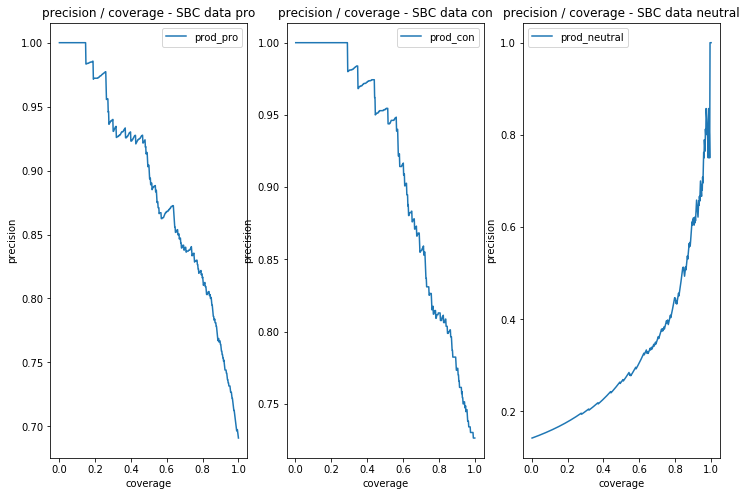

In [5]:
from wealth_util import calculate_statistics, plot_graph

pro_con_statistics = calculate_statistics('./wealth_test_set.csv', pro_con_scores)
plot_graph(examples_list=[pro_con_statistics], labels=['prod'])

# 5. Fine tune the pro con service
It is possible to fine tune the service
we need csv, lables are different
much slower since it not use GPU
discuss speeds
we can supply docker image, both for GPU and non GPU

docker run -p 8000:8000 us.icr.iodocker run -p 8000:8000 us.icr.io/ris2-debater/pro-con:4.4.b37/ris2-debater/pro-con:4.4.b37
http://localhost:8000/model.html

can upload data sets  and fine tune over the base image
explain what is epoch, and tumb of rull to set it


# 5. Generate coverage - precision curve for the fine tuned model.

ProConClient: 100%|██████████| 507/507 [00:54<00:00,  9.27it/s]


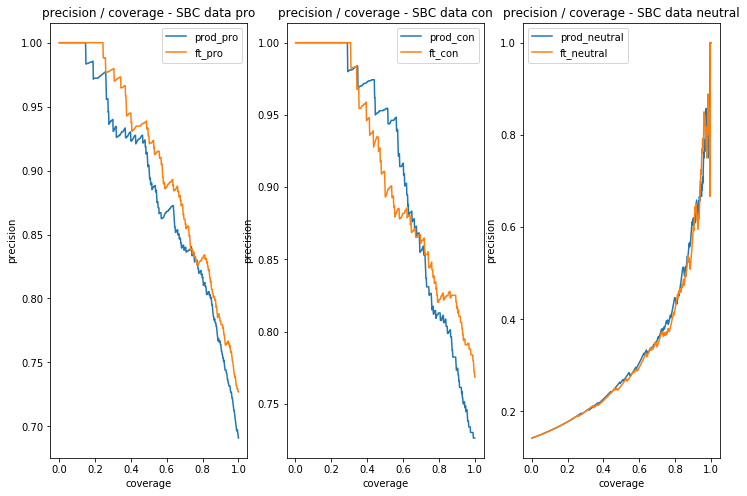

In [6]:
pro_con_client.set_host('http://localhost:8000')
ft_pro_con_scores = pro_con_client.run(sentence_topic_dicts)

ft_pro_con_statistics = calculate_statistics('./wealth_test_set.csv', ft_pro_con_scores)
plot_graph(examples_list=[pro_con_statistics, ft_pro_con_statistics], labels=['prod', 'ft'])

# 6. Generate narrative using the fine tuned model 
We will start by selecting the thr
it is possible to pass costumization object and to change defaults
there are two main algorithms for speech generation key point based and cluster based, cluster based works better on small data. so we will use it it this case

In [7]:
dominant_concept = 'Redistribution of income and wealth'

speech = debater_api.get_narrative_generation_client().run(topic=topic,
                                                           dc=dominant_concept,
                                                           sentences=arguments,
                                                           pro_con_scores=pro_con_scores,
                                                           polarity=Polarity.PRO)

print('\n\n' + str(speech))

28/04/2021 16:12:35, SpeechResultResponse=60895f43b1f0d509663a8cb6, motionGenerationid=0, status=RUNNING, started to wait at 28/04/2021 16:12:35
28/04/2021 16:12:46, SpeechResultResponse=60895f43b1f0d509663a8cb6, motionGenerationid=0, status=RUNNING, started to wait at 28/04/2021 16:12:35


Hello and welcome everyone. The following speech is based on 507 arguments contributed by the crowd, supporting the idea that It is time to redistribute the wealth. 

There are four issues the crowd has raised, supporting the perception that It is time to redistribute the wealth: government, societies, education and Workforce. 

Let's explore the issue of government.  Since in the midst of the pandemic, people need financial help, they cannot pay for health care, and they cannot pay their debts,   and because there is no need for people to be having a lot of money that they don't even need it's just sitting in banks when there are people living on the streets,  then obviously i think we should redis